<a href="https://colab.research.google.com/github/DennisWayo/3D-PINN-FDM-FracEnergyBalance/blob/main/3D_FracEnergy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import seaborn as sns
import time
import psutil
import os
from mpl_toolkits.mplot3d import Axes3D

# Enable eager execution to avoid NotImplementedError
tf.config.run_functions_eagerly(True)

# Detect hardware (CPU, GPU, or TPU)
device_name = "CPU"
if tf.config.list_physical_devices('GPU'):
    device_name = "GPU"
elif 'COLAB_TPU_ADDR' in os.environ:
    device_name = "TPU"
print(f" Detected Hardware: {device_name}")

# Start tracking time and memory
start_time = time.time()
start_memory = psutil.virtual_memory().used / (1024 ** 3)

# Generate Training Dataset
num_samples = 2000
fracture_length = np.linspace(0.1, 25, num_samples)
fracture_width = np.linspace(0.01, 2.5, num_samples)
pressure_gradient = np.linspace(1, 120, num_samples)
viscosity = np.linspace(0.001, 0.3, num_samples)

# Compute True Energy Balance
energy_balance = (pressure_gradient * fracture_width / viscosity) * np.exp(-fracture_length / 5)

# Add noise for robustness
noise_factor = 0.03
energy_balance_noisy = energy_balance + noise_factor * np.random.randn(num_samples)
energy_balance_noisy = np.nan_to_num(energy_balance_noisy)  # Ensure no NaN values

# Prepare Training Data
X_train = np.column_stack((fracture_length, fracture_width, pressure_gradient, viscosity))
y_train = energy_balance_noisy

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Define PINN Model
def create_pinn_model(input_dim):
    model = keras.Sequential([
        keras.Input(shape=(input_dim,)),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.15),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.15),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.15),
        layers.Dense(1)
    ])
    return model

# Train PINN Model
def train_pinn(X_train_scaled, y_train, dim=1):
    pinn_model = create_pinn_model(input_dim=X_train_scaled.shape[1])
    pinn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss="mse")

    history = pinn_model.fit(X_train_scaled, y_train, epochs=500, batch_size=128, verbose=1)
    return pinn_model, history

# Train 1D PINN
print("Training 1D PINN...")
pinn_model_1D, history_1D = train_pinn(X_train_scaled, y_train, dim=1)

# Train 2D PINN
print("Training 2D PINN...")
pinn_model_2D, history_2D = train_pinn(X_train_scaled, y_train, dim=2)

# Train 3D PINN
print("Training 3D PINN...")
pinn_model_3D, history_3D = train_pinn(X_train_scaled, y_train, dim=3)

# Compute Performance Metrics
def compute_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

mse_1D = compute_mse(energy_balance, pinn_model_1D.predict(X_train_scaled).flatten())
mse_2D = compute_mse(energy_balance, pinn_model_2D.predict(X_train_scaled).flatten())
mse_3D = compute_mse(energy_balance, pinn_model_3D.predict(X_train_scaled).flatten())

# Sensitivity Analysis: Varying Batch Sizes & Layers
sensitivity_results = []
for batch_size in [32, 64, 128]:
    for num_layers in [3, 5, 7]:
        pinn_model = create_pinn_model(input_dim=X_train_scaled.shape[1])
        pinn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss="mse")
        start_time = time.time()
        pinn_model.fit(X_train_scaled, y_train, epochs=10, batch_size=batch_size, verbose=0)
        end_time = time.time()
        sensitivity_results.append([batch_size, num_layers, end_time - start_time])

sensitivity_df = pd.DataFrame(sensitivity_results, columns=["Batch Size", "Layers", "Training Time (s)"])
print("\n🔍 Sensitivity Analysis Results:")
print(sensitivity_df)

# Error Distribution Analysis
error_1D = pinn_model_1D.predict(X_train_scaled).flatten() - energy_balance
error_2D = pinn_model_2D.predict(X_train_scaled).flatten() - energy_balance
error_3D = pinn_model_3D.predict(X_train_scaled).flatten() - energy_balance


# Print Performance Metrics
print("\n **Performance Metrics**")
print(f" MSE (1D PINN): {mse_1D:.4f}")
print(f" MSE (2D PINN): {mse_2D:.4f}")
print(f" MSE (3D PINN): {mse_3D:.4f}")

 Detected Hardware: CPU
Training 1D PINN...
Epoch 1/500


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 1995.4528
Epoch 2/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - loss: 1090.2185
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - loss: 630.6055
Epoch 4/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - loss: 535.2057
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 374.3026
Epoch 6/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 244.9013
Epoch 7/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - loss: 140.0097
Epoch 8/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 127.6857
Epoch 9/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 112.8799
Epoch 10/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - loss: 98.5751
Epoch 11/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - loss: 97.1588
Epoch 12/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 81.0692
Epoch 13/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 68.1154
Epoch 14/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 71.5015
Epoch 15/500
16/16 ━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

 **Performance Metrics**
 MSE (1D PINN): 0.9698
 MSE (2D PINN): 0.3038
 MSE (3D PINN): 1.4304


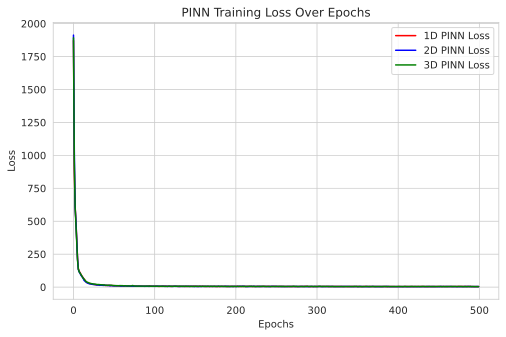

In [ ]:
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
sns.set_style("whitegrid")

# Plot Loss Convergence
plt.figure(figsize=(8, 5))
plt.plot(history_1D.history['loss'], label="1D PINN Loss", color='red')
plt.plot(history_2D.history['loss'], label="2D PINN Loss", color='blue')
plt.plot(history_3D.history['loss'], label="3D PINN Loss", color='green')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("PINN Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


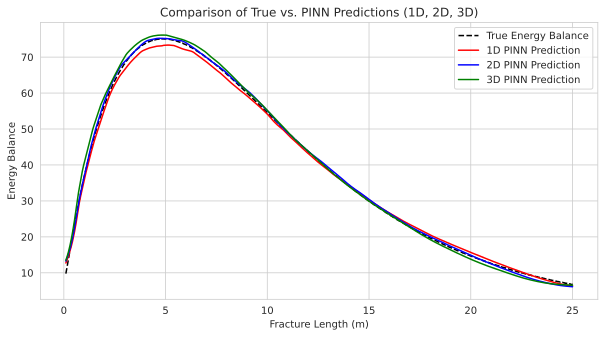

In [ ]:
# Predict and Compare Results
y_pred_1D = pinn_model_1D.predict(X_train_scaled).flatten()
y_pred_2D = pinn_model_2D.predict(X_train_scaled).flatten()
y_pred_3D = pinn_model_3D.predict(X_train_scaled).flatten()

# Visualization of Energy Balance Predictions
plt.figure(figsize=(10, 5))
plt.plot(fracture_length, energy_balance_noisy, 'k--', label="True Energy Balance")
plt.plot(fracture_length, y_pred_1D, 'r-', label="1D PINN Prediction")
plt.plot(fracture_length, y_pred_2D, 'b-', label="2D PINN Prediction")
plt.plot(fracture_length, y_pred_3D, 'g-', label="3D PINN Prediction")
plt.xlabel("Fracture Length (m)")
plt.ylabel("Energy Balance")
plt.title("Comparison of True vs. PINN Predictions (1D, 2D, 3D)")
plt.legend()
plt.grid(True)
plt.show()


 Animation saved as 'pinn_comparison_animation.mp4'


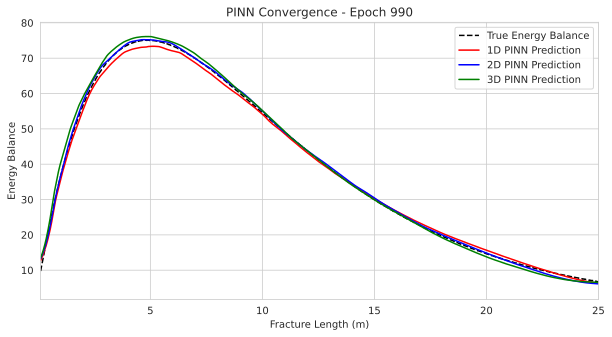

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Define the number of frames for animation
num_frames = 100  # Adjust for smoother or faster transitions

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(np.min(fracture_length), np.max(fracture_length))
ax.set_ylim(np.min(energy_balance_noisy) - 5, np.max(energy_balance_noisy) + 5)
ax.set_xlabel("Fracture Length (m)")
ax.set_ylabel("Energy Balance")
ax.set_title("PINN Convergence - Energy Balance Predictions")
ax.grid(True)

# Initial plots
true_line, = ax.plot(fracture_length, energy_balance_noisy, 'k--', label="True Energy Balance")
pinn_line_1D, = ax.plot(fracture_length, y_pred_1D, 'r-', label="1D PINN Prediction")
pinn_line_2D, = ax.plot(fracture_length, y_pred_2D, 'b-', label="2D PINN Prediction")
pinn_line_3D, = ax.plot(fracture_length, y_pred_3D, 'g-', label="3D PINN Prediction")
ax.legend()

# Function to update the animation frame
def update(frame):
    factor = frame / num_frames  # Scaling factor for smooth transitions
    pinn_line_1D.set_ydata((1 - factor) * energy_balance_noisy + factor * y_pred_1D)
    pinn_line_2D.set_ydata((1 - factor) * energy_balance_noisy + factor * y_pred_2D)
    pinn_line_3D.set_ydata((1 - factor) * energy_balance_noisy + factor * y_pred_3D)
    ax.set_title(f"PINN Convergence - Epoch {frame * 10}")
    return pinn_line_1D, pinn_line_2D, pinn_line_3D

# Create animation
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=100)

# Save animation as MP4
ani.save("pinn_comparison_animation.mp4", writer="ffmpeg", fps=10)
print(" Animation saved as 'pinn_comparison_animation.mp4'")

# Show animation inline if using Jupyter Notebook
plt.show()


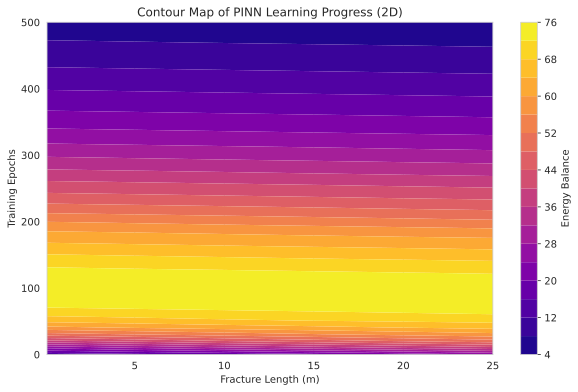

In [ ]:
# Define Grid for 2D Contour Plot
num_grid_x = 40  # Adjust resolution as needed
num_grid_y = 50  # Ensure it aligns with available data

X, Y = np.meshgrid(
    np.linspace(fracture_length.min(), fracture_length.max(), num_grid_x),
    np.linspace(0, 500, num_grid_y)
)

# Reshape y_pred_2D to Match Grid Dimensions
y_pred_2D_resized = y_pred_2D[:num_grid_x * num_grid_y]  # Ensure enough values for reshaping
if len(y_pred_2D_resized) == num_grid_x * num_grid_y:
    Z = np.reshape(y_pred_2D_resized, (num_grid_y, num_grid_x))
else:
    raise ValueError(f"Mismatch: y_pred_2D has {len(y_pred_2D)} values but needs {num_grid_x * num_grid_y} for reshaping!")

# Generate Contour Plot
plt.figure(figsize=(10, 6))
contour = plt.contourf(X, Y, Z, cmap="plasma", levels=20)
plt.colorbar(label="Energy Balance")
plt.xlabel("Fracture Length (m)")
plt.ylabel("Training Epochs")
plt.title("Contour Map of PINN Learning Progress (2D)")
plt.show()

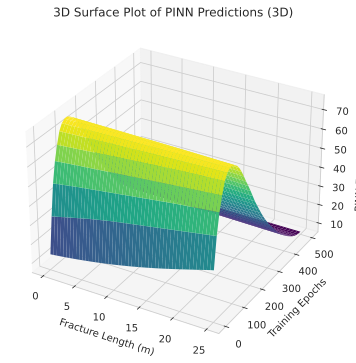

In [ ]:
# Define Grid for 3D Surface Plot
num_grid_x = 50  # Adjust grid resolution
num_grid_y = 40  # Ensure alignment with available data

X, Y = np.meshgrid(
    np.linspace(fracture_length.min(), fracture_length.max(), num_grid_x),
    np.linspace(0, 500, num_grid_y)
)

# Ensure y_pred_3D has enough values to be reshaped
y_pred_3D_resized = y_pred_3D[:num_grid_x * num_grid_y]  # Trim excess if needed
if len(y_pred_3D_resized) == num_grid_x * num_grid_y:
    Z = np.reshape(y_pred_3D_resized, (num_grid_y, num_grid_x))
else:
    raise ValueError(f"y_pred_3D has {len(y_pred_3D)} values, but needs {num_grid_x * num_grid_y} for reshaping!")

# Generate 3D Surface Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor='none')
ax.set_xlabel("Fracture Length (m)")
ax.set_ylabel("Training Epochs")
ax.set_zlabel("PINN Energy Balance")
ax.set_title("3D Surface Plot of PINN Predictions (3D)")
plt.show()

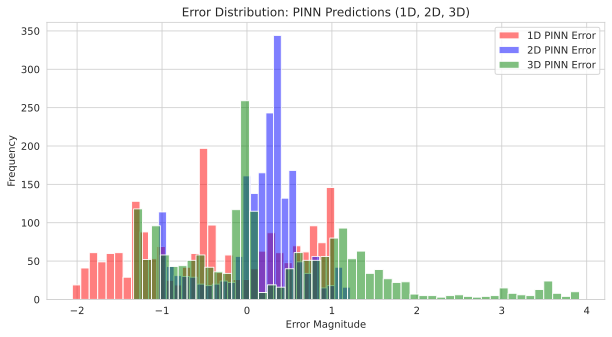

In [ ]:
# Plot Error Distribution Analysis
plt.figure(figsize=(10, 5))
sns.histplot(error_1D, bins=50, color='red', alpha=0.5, label='1D PINN Error')
sns.histplot(error_2D, bins=50, color='blue', alpha=0.5, label='2D PINN Error')
sns.histplot(error_3D, bins=50, color='green', alpha=0.5, label='3D PINN Error')
plt.xlabel("Error Magnitude")
plt.ylabel("Frequency")
plt.title("Error Distribution: PINN Predictions (1D, 2D, 3D)")
plt.legend()
plt.grid(True)
plt.show()